In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tsfel as ts

**Coding a classifier to try to predict the number of zeros in the 6 month prediction period of a timeseries**

In [59]:
train = np.load('../data/temporal_feature_train.npy', allow_pickle=True)

In [60]:
def classification(data):
    for i in range(data.shape[0]):
        if data[i, -1] != 0:
            data[i, -1] = 1
    return data


def resample(data):
    print('Before:')
    print(len(data[data[:, -1] == 0]))
    print(len(data[data[:, -1] == 1]))
    if len(data[data[:, -1] == 0]) < len(data[data[:, -1] == 1]):
        dif =  len(data[data[:, -1] == 1]) - len(data[data[:, -1] == 0])
        print(dif)
        zeros = data[data[:, -1] == 0]
        rand_zeros = zeros[np.random.randint(0, zeros.shape[0], dif), :]
        data = np.append(data, rand_zeros, axis=0)
    else:
        dif = len(data[data[:, -1] == 0]) - len(data[data[:, -1] == 1])
        ones = data[data[:, -1] == 1]
        rand_ones = ones[np.random.randint(0, ones.shape[0], dif), :]
        data = np.append(data, rand_ones, axis=0)
    print('')
    print('After:')
    print(len(data[data[:, -1] == 0]))
    print(len(data[data[:, -1] == 1]))
    return data



train_classified = classification(train)
train_resampled = resample(train_classified)

Before:
4421
6030
1609

After:
6030
6030


In [74]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(train_resampled.shape[1] - 1, 20)
        self.fc2 = nn.Linear(20, 5)
        self.fc3 = nn.Linear(5, 1)
        self.relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()
        self.hardswish = nn.Hardswish()
        self.sigmoid = nn.Sigmoid()
        self.initialise_weights()
    

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x
    
    
    def initialise_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.uniform_(m.weight, -0.1, 0.1)

In [75]:
# Train model
torch.manual_seed(42)
running_loss = 0
NN = NN()
batchSize_NN = 20
maxEpochs_NN = 100
criterion_NN = nn.BCELoss()
optimiser_NN = torch.optim.Adam(NN.parameters(), lr=0.002)
optimiser_NN.zero_grad()
trainloader_NN = torch.utils.data.DataLoader(train_resampled, batch_size=batchSize_NN, shuffle=True)
losses_NN = []
epochs_NN = []
for epoch in range(1, maxEpochs_NN + 1):
    for batch in trainloader_NN:
        optimiser_NN.zero_grad()
        y_vals = batch[:, -1]
        y_vals = torch.reshape(y_vals, (len(y_vals), 1))
        features = batch[:, 0:-1]
        y_pred = NN(features.float())
        loss = criterion_NN(y_pred, y_vals.float())
        loss.backward()
        optimiser_NN.step()
        loss = loss.item()
        running_loss += loss
    average_loss = (running_loss / (train_resampled.shape[0] / batchSize_NN))
    print('Loss at epoch', epoch, 'is', average_loss)
    losses_NN.append(average_loss)
    epochs_NN.append(epoch)
    running_loss = 0

Loss at epoch 1 is 0.5302442140247098
Loss at epoch 2 is 0.5107197637729977
Loss at epoch 3 is 0.5093582621706065
Loss at epoch 4 is 0.5061620829710319
Loss at epoch 5 is 0.5033629296678018
Loss at epoch 6 is 0.5006433922803619
Loss at epoch 7 is 0.49924574073274336
Loss at epoch 8 is 0.4984011593001399
Loss at epoch 9 is 0.4980130064645612
Loss at epoch 10 is 0.4971049366948221
Loss at epoch 11 is 0.49624727404433894
Loss at epoch 12 is 0.49609906828126704
Loss at epoch 13 is 0.49539025367591316
Loss at epoch 14 is 0.49490087408924577
Loss at epoch 15 is 0.49374977683348836
Loss at epoch 16 is 0.49346419884691983
Loss at epoch 17 is 0.49314932547398466
Loss at epoch 18 is 0.4926150623047925
Loss at epoch 19 is 0.49214541286872593
Loss at epoch 20 is 0.4916761982104869
Loss at epoch 21 is 0.4908176020504428
Loss at epoch 22 is 0.4909062926004182
Loss at epoch 23 is 0.49049083821809114
Loss at epoch 24 is 0.4902211526288322
Loss at epoch 25 is 0.49004911877227264
Loss at epoch 26 is 0.4

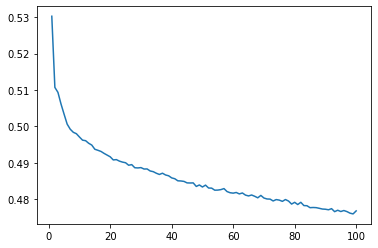

In [76]:
plt.plot(epochs_NN, losses_NN)
plt.show()

In [77]:
test = np.load('../data/temporal_feature_test.npy', allow_pickle=True)

In [78]:
test_classified = classification(test)

In [80]:
#Encode data with trained encoder and attached column to use for colour coding
def predict(data):
    past_vols = data[:, 0:-1]
    y_labels = data[:, -1]
    print('Size of scaled dataset:', np.shape(past_vols))
    torch_array = torch.from_numpy(past_vols).float()
    preds = NN(torch_array).detach()
    for i in range(preds.shape[0]):
        if preds[i] < 0.5:
            preds[i] = 0
        else:
            preds[i] = 1
    accuracy = round(accuracy_score(y_labels, preds), 4) * 100
    print(confusion_matrix(y_labels, preds))
    print(len(preds[preds == 0]))
    print(len(preds[preds == 1]))
    print(len(preds))
    print('')
    print(accuracy, '%')
    return preds


preds = predict(test_classified)

Size of scaled dataset: (10451, 18)
[[2887  485]
 [1668 5411]]
4555
5896
10451

79.4 %


In [83]:
np.save('forecast_classification', preds, allow_pickle=True)